In [61]:
import cv2
import matplotlib.pyplot as plt
from ex1_utils import *
import time

# Lucas Kanade

In [10]:
def lucaskanade(im1, im2, N):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    It = im2 - im1

    Ix2 = Ix * Ix
    IxIt = Ix * It

    Iy2 = Iy * Iy
    IyIt = Iy * It

    IxIy = Ix * Iy

    kernel = np.ones((N,N))

    SIx2 = cv2.filter2D(Ix2, -1, kernel)
    SIxIt = cv2.filter2D(IxIt, -1, kernel)

    SIy2 = cv2.filter2D(Iy2, -1, kernel)
    SIyIt = cv2.filter2D(IyIt, -1, kernel)

    SIxIy = cv2.filter2D(IxIy, -1, kernel)

    D = (SIx2 * SIy2) - (SIxIy**2)
    epsilon = 1e-6
    D = D + epsilon

    u = (-SIy2 * SIxIt + SIxIy * SIyIt) / D
    v = (SIxIy * SIxIt - SIx2 * SIyIt) / D

    return u, v

# Lucas Kanade with Harris response

In [23]:
def lucaskanadeharris(im1, im2, N, HD=5, k=0.04, H_threshold = 0.01):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    It = im2 - im1

    Ix2 = Ix * Ix
    IxIt = Ix * It

    Iy2 = Iy * Iy
    IyIt = Iy * It

    IxIy = Ix * Iy

    kernel = np.ones((N,N))

    SIx2 = cv2.filter2D(Ix2, -1, kernel)
    SIxIt = cv2.filter2D(IxIt, -1, kernel)

    SIy2 = cv2.filter2D(Iy2, -1, kernel)
    SIyIt = cv2.filter2D(IyIt, -1, kernel)

    SIxIy = cv2.filter2D(IxIy, -1, kernel)

    D = (SIx2 * SIy2) - (SIxIy**2)
    epsilon = 1e-6
    D = D + epsilon

    u = (-SIy2 * SIxIt + SIxIy * SIyIt) / D
    v = (SIxIy * SIxIt - SIx2 * SIyIt) / D

    #Harris corner detector
    harris_kernel = np.ones((HD, HD))

    H_Ix2 = cv2.filter2D(Ix2, -1, harris_kernel)
    H_Iy2 = cv2.filter2D(Iy2, -1, harris_kernel)
    H_Ixy = cv2.filter2D(IxIy, -1, harris_kernel)

    det = (H_Ix2 * H_Iy2) - (H_Ixy ** 2)
    trace = H_Ix2 + H_Iy2

    c = det - k * trace

    corners_matrix = (c > H_threshold)
    return u*corners_matrix, v*corners_matrix

# Lucas Kanade with pyramids

In [ ]:
def scale_down(img, lvls):
    pyramid = [img]
    for i in range(1, lvls):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def warp_image(img, U, V):
    h, w = img.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))

    map_x = (grid_x + U).astype(np.float32)
    map_y = (grid_y + V).astype(np.float32)
    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

def pyramidal_lucaskanade(img1, img2, N, levels=3):

    pyramid1 = scale_down(img1, levels)
    pyramid2 = scale_down(img2, levels)

    U = np.zeros_like(pyramid1[-1], dtype=np.float32)
    V = np.zeros_like(pyramid1[-1], dtype=np.float32)

    for i in reversed(range(levels)):
        cur_img1 = pyramid1[i]
        cur_img2 = pyramid2[i]

        if i != levels -1:
            U = cv2.pyrUp(U) *2
            V = cv2.pyrUp(V) *2

            #ValueError: operands could not be broadcast together with shapes (416,607) (416,608) (416,607) 
            U = cv2.resize(U, (cur_img1.shape[1], cur_img1.shape[0]))
            V = cv2.resize(V, (cur_img1.shape[1], cur_img1.shape[0]))
        
        img2_warp = cv2.remap(cur_img2, U, V, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        U_bar, V_bar = lucaskanade(cur_img1, img2_warp, N)

        U += U_bar
        V += V_bar
    
    return U, V

# Horn Schunk

In [75]:
def hornschunck(im1, im2, n_iters, lam, threshold):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy

    It = im2 - im1

    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)

    kernel = np.array([[0, 1/4, 0],
                       [1/4, 0, 1/4],
                       [0, 1/4, 0]])
    
    N = im1.shape[0] * im1.shape[1]

    for _ in range(n_iters):

        u_bar = cv2.filter2D(u, -1, kernel)
        v_bar = cv2.filter2D(v, -1, kernel)

        P = It + Ix * u_bar + Iy * v_bar
        D = Ix2 + Iy2 + lam + 1e-6

        u = u_bar - Ix * (P / D)
        v = v_bar - Iy * (P / D)

        sq_diff_u = (u_bar - u) ** 2
        sq_diff_v = (v_bar - v) ** 2

        total_diffs = sq_diff_u + sq_diff_v
        if (np.sum(total_diffs)/N) < threshold ** 2:
            return u_bar, v_bar

    return u, v

# Lucas Kanade initialized Horn Scunck

In [ ]:
def hornschunck_lk(im1, im2, n_iters, lam, threshold):

    sigma = min(im1.shape)*0.005
    img1 = gausssmooth(im1, sigma)
    img2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(img1, sigma)
    Ix2, Iy2 = gaussderiv(img2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy

    It = im2 - im1

    u, v = lucaskanade(im1, im2, 4)

    kernel = np.array([[0, 1/4, 0],
                       [1/4, 0, 1/4],
                       [0, 1/4, 0]])
    
    N = im1.shape[0] * im1.shape[1]

    for _ in range(n_iters):

        u_bar = cv2.filter2D(u, -1, kernel)
        v_bar = cv2.filter2D(v, -1, kernel)

        P = It + Ix * u_bar + Iy * v_bar
        D = Ix2 + Iy2 + lam + 1e-6

        u = u_bar - Ix * (P / D)
        v = v_bar - Iy * (P / D)

        sq_diff_u = (u_bar - u) ** 2
        sq_diff_v = (v_bar - v) ** 2

        total_diffs = sq_diff_u + sq_diff_v
        if (np.sum(total_diffs)/N) < threshold ** 2:
            return u_bar, v_bar

    return u, v

# Image importing

In [33]:
img1 = cv2.imread("disparity/cporta_left.png")
img2 = cv2.imread("disparity/cporta_right.png")


img1 = np.random.rand(200, 200).astype(np.float32)
img2 = img1.copy()
img2 = rotate_image(img2, -1)

if len(img1.shape) >= 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

if len(img2.shape) >= 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Visualisation

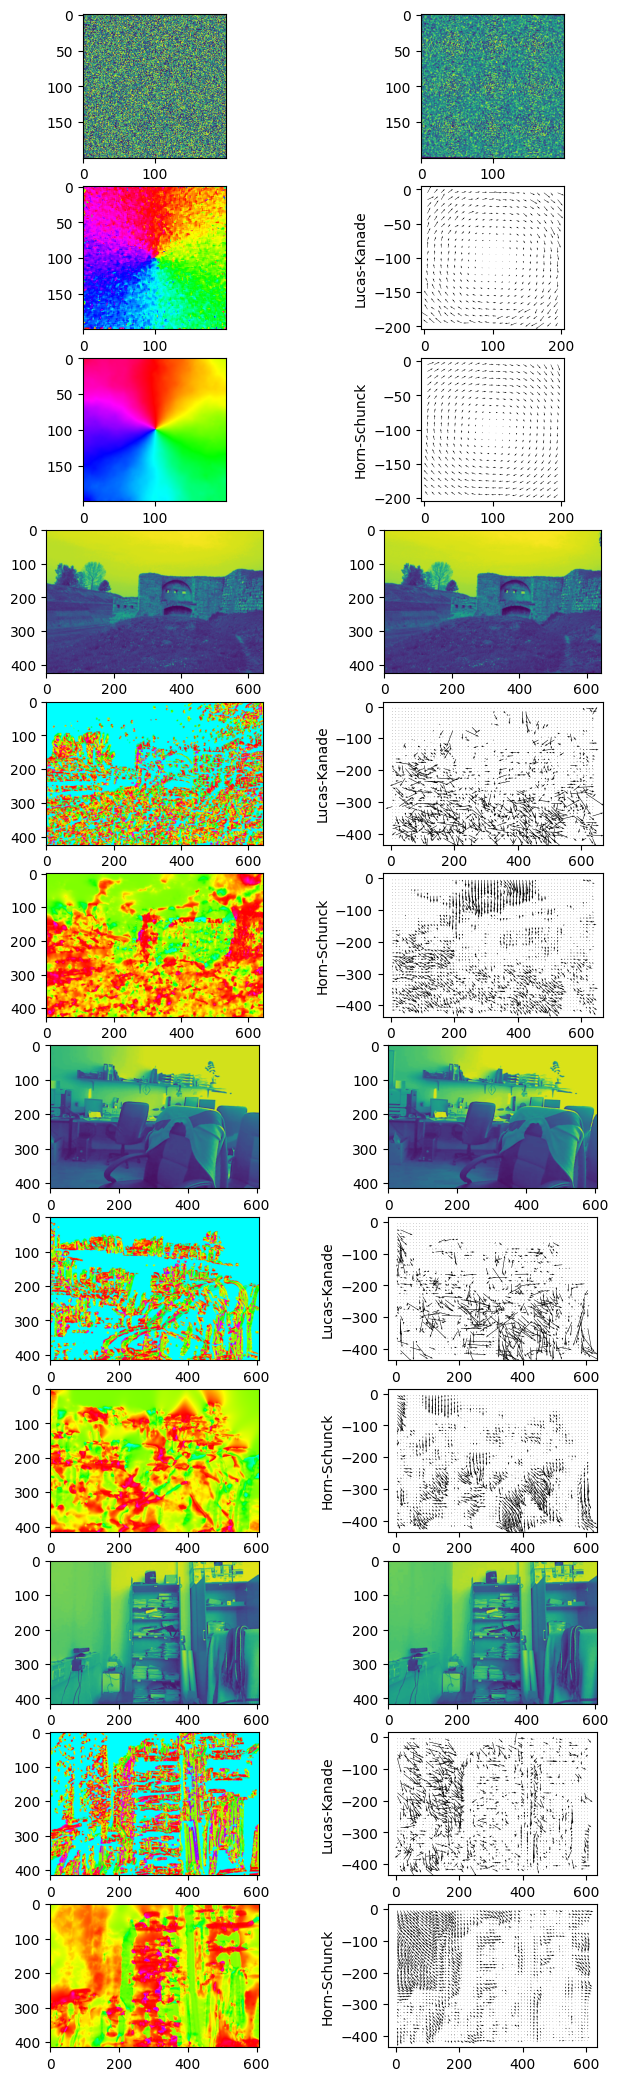

In [81]:
images = ["rotation", "cporta", "office", "office2"]
fig, axes = plt.subplots(len(images) * 3, 2, figsize=(8, len(images)*3*2.2))

for i, img in enumerate(images):

    if img != "rotation":
        img1 = cv2.imread(f"disparity/{img}_left.png")
        img2 = cv2.imread(f"disparity/{img}_right.png")

        if len(img1.shape) >= 3:
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

        if len(img2.shape) >= 3:
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    else:
        img1 = np.random.rand(200, 200).astype(np.float32)
        img2 = img1.copy()
        img2 = rotate_image(img2, -1)
        

    U_lk, V_lk = lucaskanade(img1, img2, 4)
    U_hs, V_hs = hornschunck(img1, img2, 1000, 15, 0.0001)

    axes[i*3][0].imshow(img1)
    axes[i*3][1].imshow(img2)
    show_flow(U_lk ,V_lk, axes[i*3+1][0], type='angle')
    show_flow(U_lk ,V_lk ,axes[i*3+1][1] ,type='field', set_aspect=True)
    show_flow(U_hs ,V_hs, axes[i*3+2][0], type='angle')
    show_flow(U_hs ,V_hs ,axes[i*3+2][1] ,type='field', set_aspect=True)

    axes[i*3+1][1].set_ylabel("Lucas-Kanade")
    axes[i*3+2][1].set_ylabel("Horn-Schunck")
plt.savefig("big_image.pdf", bbox_inches="tight")

#fig2, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
#ax2_11.imshow(img1)
#ax2_12.imshow(img2)
#show_flow(U_hs ,V_hs, ax2_21, type='angle')
#show_flow(U_hs ,V_hs ,ax2_22 ,type='field', set_aspect=True)
#fig2.suptitle('Horn-Schunck Optical Flow')

#plt.show()

# Time comparison

Lucas-Kanade took: 0.03377532958984375
Regular Horn-Schunck took: 13.687411308288574
Lucas-Kanade initialized Horn-Schunck took: 10.737476110458374


Text(0.5, 0.98, 'Lucas-Kanade initialized Horn-Schunck Optical Flow')

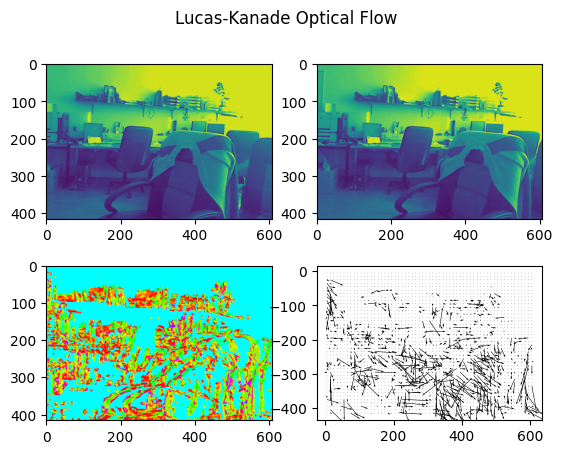

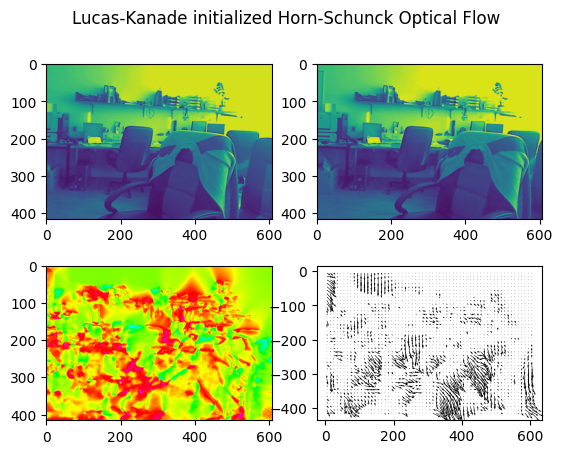

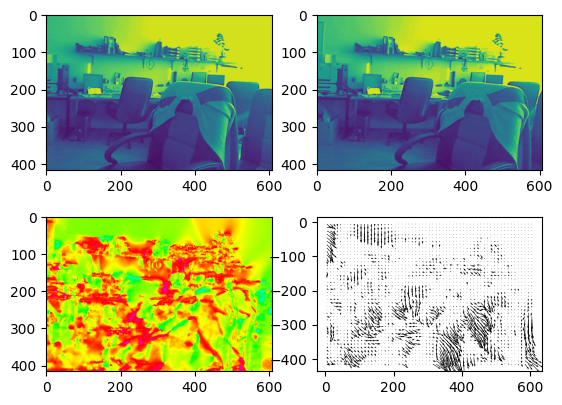

In [ ]:
img1 = cv2.imread("disparity/office_left.png")
img2 = cv2.imread("disparity/office_right.png")


#img1 = np.random.rand(200, 200).astype(np.float32)
#img2 = img1.copy()
#img2 = rotate_image(img2, -1)

if len(img1.shape) >= 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

if len(img2.shape) >= 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

start = time.time()
U_lk, V_lk = lucaskanade(img1, img2, 4)
finish = time.time()
print(f"Lucas-Kanade took: {finish - start}")

start = time.time()
U_hs1, V_hs1 = hornschunck(img1, img2, 1000, 15, 0.0001)
finish = time.time()
print(f"Regular Horn-Schunck took: {finish - start}")

start = time.time()
U_hs2, V_hs2 = hornschunck_lk(img1, img2, 1000, 15, 0.0001)
finish = time.time()
print(f"Lucas-Kanade initialized Horn-Schunck took: {finish - start}")

fig1, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_lk ,V_lk, ax2_21, type='angle')
show_flow(U_lk ,V_lk ,ax2_22 ,type='field', set_aspect=True)
fig1.suptitle('Lucas-Kanade Optical Flow')

fig2, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_hs1 ,V_hs1, ax2_21, type='angle')
show_flow(U_hs1 ,V_hs1 ,ax2_22 ,type='field', set_aspect=True)
fig2.suptitle('Horn-Schunck Optical Flow')

fig3, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_hs2 ,V_hs2 , ax2_21, type='angle')
show_flow(U_hs2 ,V_hs2 ,ax2_22 ,type='field', set_aspect=True)
fig3.suptitle('Lucas-Kanade initialized Horn-Schunck Optical Flow')
    

Text(0.5, 0.98, 'Lucas-Kanade Optical Flow')

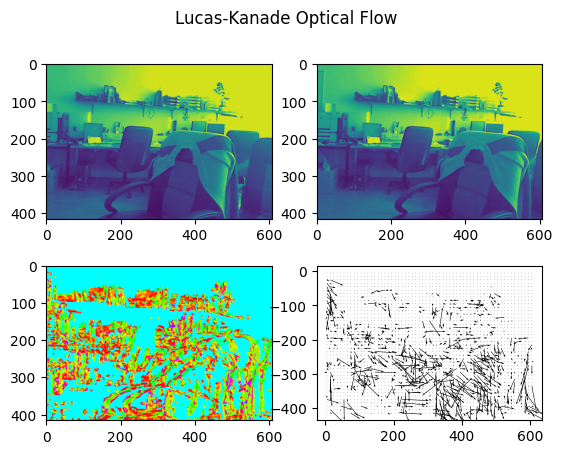

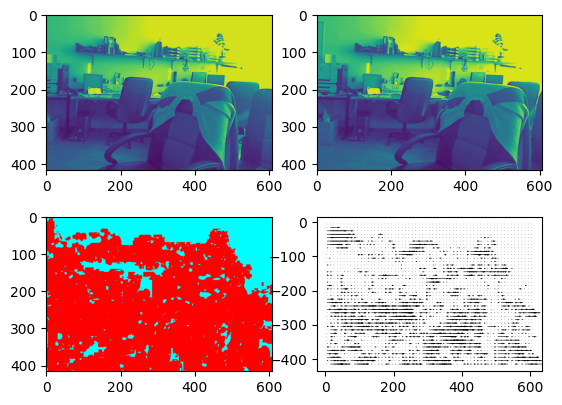

In [125]:
img1 = cv2.imread("disparity/office_left.png")
img2 = cv2.imread("disparity/office_right.png")


#img1 = np.random.rand(200, 200).astype(np.float32)
#img2 = img1.copy()
#img2 = rotate_image(img2, -1)

if len(img1.shape) >= 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

if len(img2.shape) >= 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

U_lk, V_lk = lucaskanade(img1, img2, 4)

fig1, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_lk ,V_lk, ax2_21, type='angle')
show_flow(U_lk ,V_lk ,ax2_22 ,type='field', set_aspect=True)
fig1.suptitle('Lucas-Kanade Optical Flow')

U_plk, V_plk = pyramidal_lucaskanade(img1, img2, 4, 3)

fig2, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_plk ,V_plk, ax2_21, type='angle')
show_flow(U_plk ,V_plk ,ax2_22 ,type='field', set_aspect=True)
fig1.suptitle('Lucas-Kanade Optical Flow')